### Random Survival Forests.

Inspired by the following paper: https://projecteuclid.org/journals/annals-of-applied-statistics/volume-2/issue-3/Random-survival-forests/10.1214/08-AOAS169.full

It is an ensemble of tree-based learners. A Random Survival Forest ensures that individual trees are de-correlated by:

- Building each tree on a different bootstrap sample of the oiginal training data
- Each node, only evaluate the split criterion for a randomly selected subset of features and thresholds. Predictions are formed by aggregating predictions of individual trees in the ensemble.

In [16]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

%matplotlib inline
from sklearn import set_config
from sklearn.model_selection import train_test_split

%pip install scikit-survival
from sksurv.ensemble import RandomSurvivalForest
from sksurv.metrics import concordance_index_censored

set_config(display="text") # displays text representation of estimators.

Note: you may need to restart the kernel to use updated packages.


In [ ]:
# Prepare the data.
data = pd.read_csv("data.csv")

data.columns = data.columns.str.strip() # Remove any leading or trailing white spaces in the column names.
data['Event'] = data['Event'].astype(bool) # Replace the O/1 values in the Event column with True/False values.

X, y = data.drop(['PatientID', 'SurvivalTime', 'Event'], axis=1), np.array([tuple(row) for row in data[['Event', 'SurvivalTime']].values], dtype=[('cens', '?'), ('time', '<f8')])

In [30]:
random_state = 20
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=random_state)

## Training

The most widespread split criterion is based on the log-rank test, comparing survival curves among two or more groups. Non-parametric test, meaning it does not assume any specific distribution of survival times. It compares the observed and expected number of events (e.g., deaths, failures) at different time points for each group. It is useful when we have survival data that is **censored** like in our case.

In [31]:
rsf = RandomSurvivalForest(n_estimators=1000, min_samples_split=10, min_samples_leaf=15, n_jobs=-1, random_state=random_state)
rsf.fit(X_train, y_train)

RandomSurvivalForest(min_samples_leaf=15, min_samples_split=10,
                     n_estimators=1000, n_jobs=-1, random_state=20)

## Predicting

For preidiction, a sample is dropped down each tree in the forest until it reaches a terminal node. Data in each terminal is used to non-parametrically estimate the survival and cumulative hazard function using the Kaplan-Meier and Nelson-Aalen estimator, respectively.

Let's first select a couple of patients from the test data according to the number of positive lymph nodes and age.

In [ ]:
X_test_sorted = X_test.sort_values(by=["Voxel_Volume", "age"])
X_test_sel = pd.concat((X_test_sorted.head(3), X_test_sorted.tail(3)))

X_test_sel

,Mstage,Nstage,Tstage,age,Histology_Adenocarcinoma,Histology_LargeCell,Histology_Nos,Histology_SquamousCellCarcinoma,Compactness_2,Maximum_Diameter,Sphericity,Surface_Volume_Ratio,Voxel_Volume
210,0,1,4,74.0808,0,1,0,0,0.649631,13.453624,0.866075,0.651869,640.0
15,0,0,3,77.0000,0,0,0,1,0.540955,16.763055,0.814805,0.660809,738.0
124,0,0,1,67.0000,1,0,0,0,0.511728,13.674794,0.799858,0.667874,756.0
58,0,0,2,78.0000,1,0,0,0,0.207591,98.392073,0.592111,0.143646,183955.0
150,0,2,3,71.2553,0,0,0,1,0.169012,105.919781,0.552891,0.136771,261684.0
102,0,0,4,56.8214,0,0,1,0,0.162281,155.438091,0.545451,0.130889,310977.0


By concatenating the first and last three patients, we can observe that the risk for the three last patients is a bit higher than for the first three patients.

In [33]:
pd.Series(rsf.predict(X_test_sel))

0    32.984652
1    30.420022
2    18.272664
3    50.838800
4    69.856678
5    66.420277
dtype: float64

By having a more detailed insight we can consider that the predicted survival function shows the biggest difference occurs roughly within the first 500 days.

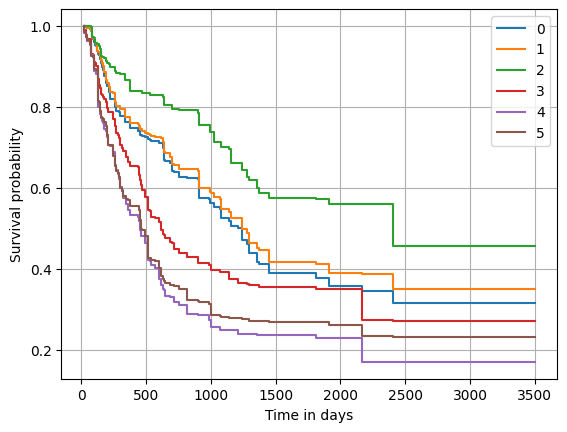

In [34]:
surv = rsf.predict_survival_function(X_test_sel, return_array=True)

for i, s in enumerate(surv):
    plt.step(rsf.unique_times_, s, where="post", label=str(i))
plt.ylabel("Survival probability")
plt.xlabel("Time in days")
plt.legend()
plt.grid(True)

We can also plot the cumulative hazard function.

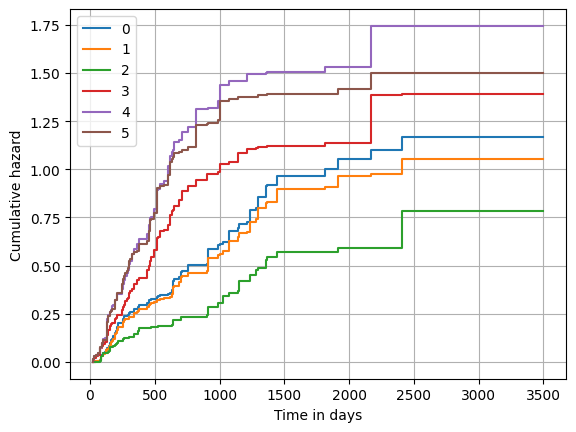

In [35]:
surv = rsf.predict_cumulative_hazard_function(X_test_sel, return_array=True)

for i, s in enumerate(surv):
    plt.step(rsf.unique_times_, s, where="post", label=str(i))
plt.ylabel("Cumulative hazard")
plt.xlabel("Time in days")
plt.legend()
plt.grid(True)

In [55]:
## Computes the c-index.
rsf.score(X_test, y_test)


0.6931818181818182

## Perumation-based Feature Importance

Implementation is based on scikit-learn's Random Forest implementation and inherits many features, such as building trees in parallel. The currently missing is feature importances. The implementation of scikit-learn of feature importance heavily relies on the *impurity* for each child node, and defines importance as the amount of decrease in impurity due to a split. In the case of survival analysis, there is no pre-node impurity measure due to censoring. Instead, one could use the magnitude of the log-rank test statistic as an importance measure. 

Definition of feature importance is non-standard in scikit-learn, instead we can use permutation to estimate feature importance.

In [52]:
from sklearn.inspection import permutation_importance

result = permutation_importance(rsf, X_test, y_test, n_repeats=15, random_state=random_state)

In [53]:
pd.DataFrame(
    {
        k: result[k]
        for k in (
            "importances_mean",
            "importances_std",
        )
    },
    index=X_test.columns,
).sort_values(by="importances_mean", ascending=False)

,importances_mean,importances_std
Nstage,0.020412,0.018434
Surface_Volume_Ratio,0.016919,0.015324
age,0.014015,0.008085
Voxel_Volume,0.009049,0.009335
Tstage,0.001263,0.002557
Mstage,0.000000,0.000000
Histology_LargeCell,-0.000715,0.000858
Histology_SquamousCellCarcinoma,-0.000842,0.001965
Histology_Nos,-0.001094,0.000963
Maximum_Diameter,-0.005177,0.013550


We can see that the **pnodes** is by far the most important feature. If its relationship to survival time is removed (by random shuffling), the conconrdance index on the test data drops on average by 0.077655 points thus, agreeing with the results from the original paper https://projecteuclid.org/journals/annals-of-applied-statistics/volume-2/issue-3/Random-survival-forests/10.1214/08-AOAS169.full